# GMM and EM
Gaussian Mixture Models and Expectation Maximization.

Updated after switch to GenCode 43, but we don't use the sequence here.

Use entire CNRCI (not train set). 

Process each cell line separately.

In [1]:
import numpy as np
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture
import scipy.stats as ss

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/


In [3]:
RCI_FILE =      'all.lncRNA_RCI.csv'  # CNRCI, 15 cell lines

In [4]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080','HUVEC','MCF.7','NCI.H460','NHEK',\
     'SK.MEL.5','SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

CELL_LINE = 0
print('Cell line for today',CELL_LINE,all_cell_lines[CELL_LINE])
EXCLUSIONS = [1]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Cell line for today 0 A549
Exclude cell line 1 H1.hESC


In [5]:
class RCI_Loader():
    def __init__(self):
        self.cache=dict() 
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        return gene_to_rci

In [6]:
def plot(X,left=None,right=None,middle=None,discrim=None,num_bins=50):
    pyplot.hist(X, bins=num_bins, density=True)
    if left is not None:
        pyplot.axvline(x=left,color='y')
    if right is not None:
        pyplot.axvline(x=right,color='y')
    if middle is not None:
        pyplot.axvline(x=middle,color='g')
    if discrim is not None:
        pyplot.axvline(x=discrim,color='r')
    pyplot.show()
    
def show_gmm(model,X):
    print(model)
    print('AIC',model.aic(X),'BIC',model.bic(X),'score',model.score(X))
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 'cov=',model.covariances_[i])

In [7]:
def place_discriminant(minRCI,maxRCI,mean1,var1,wgt1,mean2,var2,wgt2):
    bests = []
    left = None
    middle = None
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    zmin = max(mean1-3*std1,mean2-3*std2)
    zmax = min(mean1+3*std1,mean2+3*std2)
    zrange = (zmax-zmin)
    for i in range(101):
        if left is None:
            x = zrange * (i-1)/100.0 + zmin
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            left = p1-p2
        if middle is None:
            x = zrange * (i)/100.0 + zmin 
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            middle = p1-p2
        x = zrange * (i+1)/100.0 + zmin 
        p1 = ss.norm(mean1,var1).pdf(x)*wgt1
        p2 = ss.norm(mean2,var2).pdf(x)*wgt2
        right = p1-p2
        if left * right < 0.0:
            bests.append(x)
        left = middle
        middle = right
    if len(bests)==0:
        return None
    return np.mean(bests)

Cell Line 0 A549
Single mean [-0.55028835]
Double mean [0.38854397] [-2.09708433]
Gaussian discriminant -1.1185775993924987


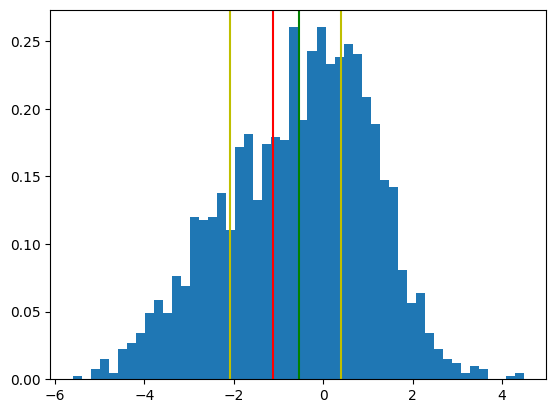

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 7717.08959873682 BIC 7728.309323138647 score -1.9110727449793905
Gaussian 0 mean= [-0.55028835] wgt= 1.0 cov= 2.6758545767204183
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 7637.06927115283 BIC 7665.118582157398 score -1.8897594824461919
Gaussian 0 mean= [0.38854397] wgt= 0.6222957687304453 cov= 1.1222723558188645
Gaussian 1 mean= [-2.09708433] wgt= 0.37770423126955466 cov= 1.3907368090070198
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 7655.216233326008 BIC 7700.095130933316 score -1.892769136106543
Gaussian 0 mean= [0.87102805] wgt= 0.38269540367538424 cov= 0.8269795420600579
Gaussian 1 mean= [-0.58045616] wgt= 0.35367256344877895 cov= 0.7098806155017029
Gaussian 2 mean= [-2.57303849] wgt= 0.2636320328758368 cov= 0.9719322945139853
Cell Line 1 H1.hESC
Single mean [-0.45944954]
Double mean [0.31091897] [-1.55251246]
Gaussian discriminant -1.079918105985635


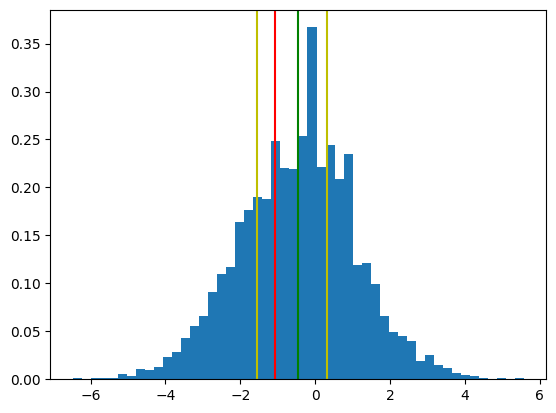

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 17345.046749501114 BIC 17357.944149891056 score -1.857040774202304
Gaussian 0 mean= [-0.45944954] wgt= 1.0 cov= 2.4017674368826123
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 17373.367220416007 BIC 17405.61072139086 score -1.8594310580869573
Gaussian 0 mean= [0.31091897] wgt= 0.5865860690745756 cov= 1.5057338471259365
Gaussian 1 mean= [-1.55251246] wgt= 0.4134139309254244 cov= 1.636286621633536
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 17356.432353337124 BIC 17408.021954896893 score -1.8569749789395078
Gaussian 0 mean= [-2.01302669] wgt= 0.31675544028566643 cov= 1.2034840599055074
Gaussian 1 mean= [-0.19813862] wgt= 0.4591835642513584 cov= 0.6958255701605998
Gaussian 2 mean= [1.20132294] wgt= 0.2240609954629752 cov= 1.281669924162828
Cell Line 2 HeLa.S3
Single mean [-1.5686552]
Double mean [-0.38409019] [-2.84444449]
Gaussian discriminant -1.742035517771689


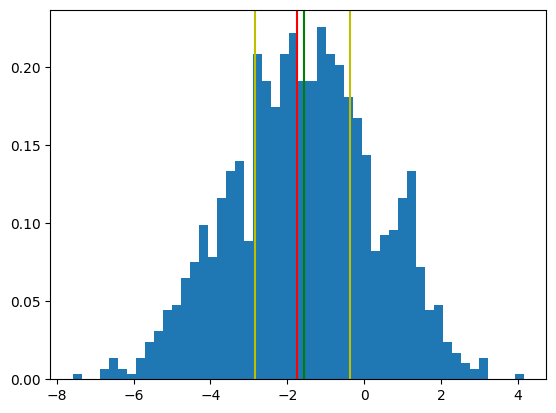

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 5102.539949065682 BIC 5112.798544163541 score -2.0426842744654174
Gaussian 0 mean= [-1.5686552] wgt= 1.0 cov= 3.4815993437406627
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 5105.1033297889 BIC 5130.749817533547 score -2.0413074237936297
Gaussian 0 mean= [-0.38409019] wgt= 0.5185388478007583 cov= 1.8972715352979506
Gaussian 1 mean= [-2.84444449] wgt= 0.48146115219924157 cov= 2.049043817925157
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 5104.633489815598 BIC 5145.667870207033 score -2.038715340470993
Gaussian 0 mean= [-1.52252538] wgt= 0.4532095678401681 cov= 0.8108568737427982
Gaussian 1 mean= [0.58780394] wgt= 0.26414591018988226 cov= 1.0481470101898405
Gaussian 2 mean= [-3.65794508] wgt= 0.2826445219699496 cov= 1.3237137409812767
Cell Line 3 HepG2
Single mean [-1.44328948]
Double mean [-3.08234971] [-0.23323595]
Gaussian discriminant -2.1645414888837102


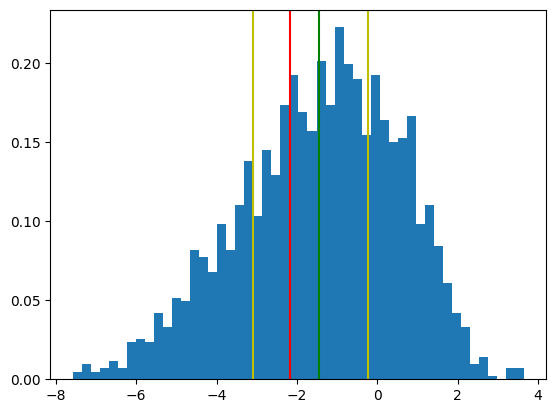

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 8001.739264640244 BIC 8012.838482970553 score -2.1046682275369064
Gaussian 0 mean= [-1.44328948] wgt= 1.0 cov= 3.9410990944904314
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 7936.07637334936 BIC 7963.824419175133 score -2.085809571934042
Gaussian 0 mean= [-3.08234971] wgt= 0.42471225726880274 cov= 2.415787327458241
Gaussian 1 mean= [-0.23323595] wgt= 0.5752877427311972 cov= 1.6195964418820419
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 7937.075796728401 BIC 7981.472670049637 score -2.084493630718
Gaussian 0 mean= [0.45138511] wgt= 0.360648088580444 cov= 0.9420859179799711
Gaussian 1 mean= [-3.98647325] wgt= 0.24115869467818712 cov= 1.575585971995802
Gaussian 2 mean= [-1.61908327] wgt= 0.39819321674136876 cov= 0.8906529724082891
Cell Line 4 HT1080
Single mean [-0.56552856]
Double mean [-2.14141361] [0.41006065]
Gaussian discriminant -1.5898311460620005


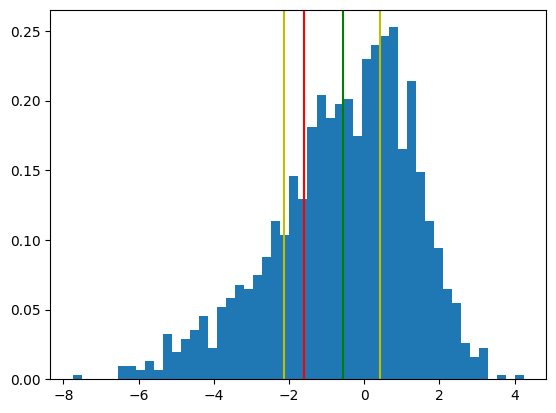

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 5245.461356348572 BIC 5255.7830481619 score -2.034728787402396
Gaussian 0 mean= [-0.56552856] wgt= 1.0 cov= 3.426642093673815
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 5151.583753990417 BIC 5177.3879835237385 score -1.9959564262385159
Gaussian 0 mean= [-2.14141361] wgt= 0.3823629419309223 cov= 2.8035264812360845
Gaussian 1 mean= [0.41006065] wgt= 0.6176370580690778 cov= 1.323205926384323
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 5150.340055693758 BIC 5191.6268229470725 score -1.9931444315581357
Gaussian 0 mean= [-1.1292465] wgt= 0.3591329353804642 cov= 0.8050581579156816
Gaussian 1 mean= [0.84713685] wgt= 0.4788172266688823 cov= 0.8537981146104264
Gaussian 2 mean= [-3.4903007] wgt= 0.16204983795065356 cov= 1.6835613712149164
Cell Line 5 HUVEC
Single mean [-1.39066083]
Double mean [-0.11564369] [-3.04311689]
Gaussian discriminant -2.1079108529891992


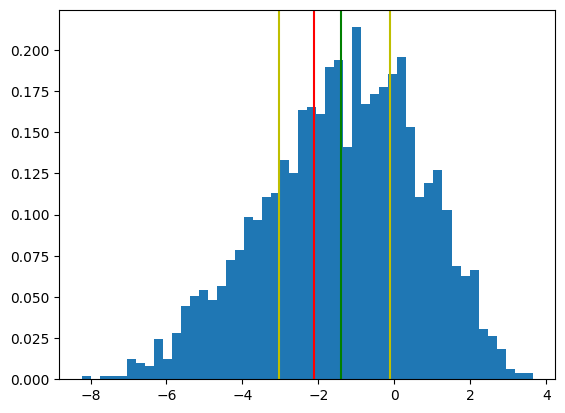

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 8937.806966508364 BIC 8949.095848031477 score -2.138297502754515
Gaussian 0 mean= [-1.39066083] wgt= 1.0 cov= 4.215289095172408
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 8879.674042004328 BIC 8907.896245812111 score -2.1229473532801166
Gaussian 0 mean= [-0.11564369] wgt= 0.5644649635945297 cov= 1.7870939729966788
Gaussian 1 mean= [-3.04311689] wgt= 0.43553503640547025 cov= 2.5247735814127656
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 8878.165222843098 BIC 8923.32074893555 score -2.1211501251419573
Gaussian 0 mean= [-4.06760999] wgt= 0.22933807480277973 cov= 1.5794503950034506
Gaussian 1 mean= [0.52707872] wgt= 0.37730420091311234 cov= 1.0982102910814293
Gaussian 2 mean= [-1.66940158] wgt= 0.3933577242841079 cov= 0.9585889967674234
Cell Line 6 MCF.7
Single mean [-1.57615471]
Double mean [-0.21930003] [-3.24613518]
Gaussian discriminant -2.3084866282876653


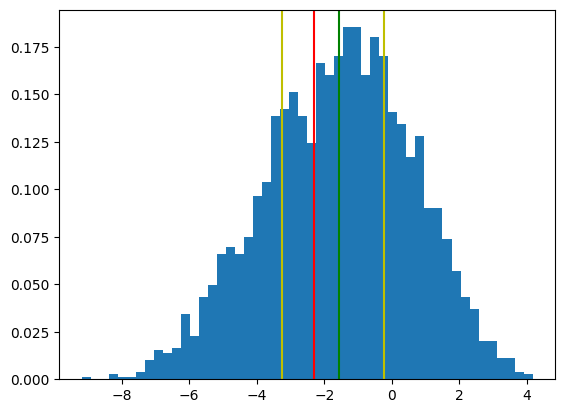

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 12986.566902569168 BIC 12998.546701319054 score -2.199689410804671
Gaussian 0 mean= [-1.57615471] wgt= 1.0 cov= 4.7659741985859965
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 12949.885193721137 BIC 12979.834690595851 score -2.19245767430043
Gaussian 0 mean= [-0.21930003] wgt= 0.5517249503111685 cov= 2.2757653011144443
Gaussian 1 mean= [-3.24613518] wgt= 0.4482750496888315 cov= 2.776101173807068
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 12961.675889802333 BIC 13009.595084801877 score -2.193438815622218
Gaussian 0 mean= [-1.57613323] wgt= 0.41138902211521383 cov= 1.237162922570726
Gaussian 1 mean= [-4.05116667] wgt= 0.27994813902962334 cov= 1.9604354555412893
Gaussian 2 mean= [0.6685799] wgt= 0.3086628388551629 cov= 1.4191023533641551
Cell Line 7 NCI.H460
Single mean [-1.52002524]
Double mean [-0.76239842] [-2.9857272]
Gaussian discriminant -3.795763283500144


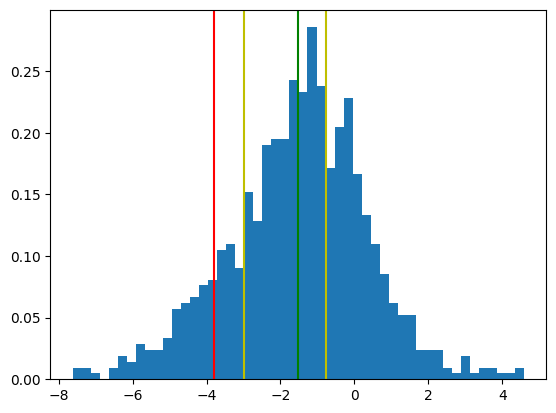

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 3541.6097772039034 BIC 3551.1259662127586 score -2.0543610785156234
Gaussian 0 mean= [-1.52002524] wgt= 1.0 cov= 3.5638640773616315
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 3543.258331639936 BIC 3567.0488041620747 score -2.0518341066434007
Gaussian 0 mean= [-0.76239842] wgt= 0.6592376121348613 cov= 2.218790031104026
Gaussian 1 mean= [-2.9857272] wgt= 0.3407623878651387 cov= 2.907301822144018
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 3536.1264897694523 BIC 3574.191245804874 score -2.0442081822122256
Gaussian 0 mean= [-1.41147735] wgt= 0.4779659712782734 cov= 1.0674109931629812
Gaussian 1 mean= [-3.91913741] wgt= 0.21605586938719035 cov= 1.8189881296241601
Gaussian 2 mean= [0.00446287] wgt= 0.3059781593345362 cov= 2.2889513392705947
Cell Line 8 NHEK
Single mean [-1.20248229]
Double mean [-0.18029053] [-2.95803146]
Gaussian discriminant -2.578237566078509


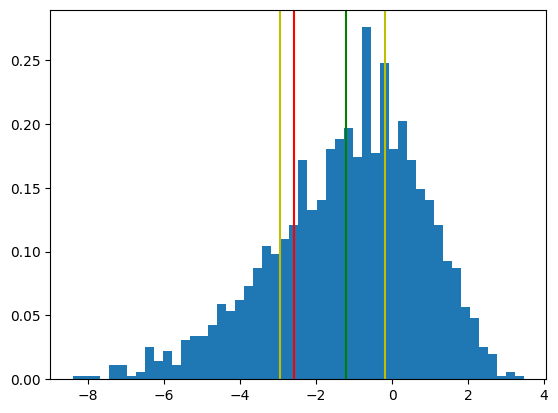

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 6296.732365060135 BIC 6307.354801828974 score -2.101781017054153
Gaussian 0 mean= [-1.20248229] wgt= 1.0 cov= 3.918407114601993
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 6206.225994213238 BIC 6232.782086135336 score -2.0695477602582626
Gaussian 0 mean= [-0.18029053] wgt= 0.6320060856553817 cov= 1.6046113875971142
Gaussian 1 mean= [-2.95803146] wgt= 0.36799391434461826 cov= 3.015742952028835
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 6210.613166795592 BIC 6253.102913870949 score -2.069009073746023
Gaussian 0 mean= [-1.47903743] wgt= 0.4000254895331616 cov= 1.0582127615843377
Gaussian 1 mean= [0.48133168] wgt= 0.39523816699608255 cov= 0.9709665400965669
Gaussian 2 mean= [-3.91269208] wgt= 0.20473634347075587 cov= 2.2287643240374146
Cell Line 9 SK.MEL.5
Single mean [-1.78587214]
Double mean [-0.7260581] [-3.51942486]
Gaussian discriminant -3.930801182004809


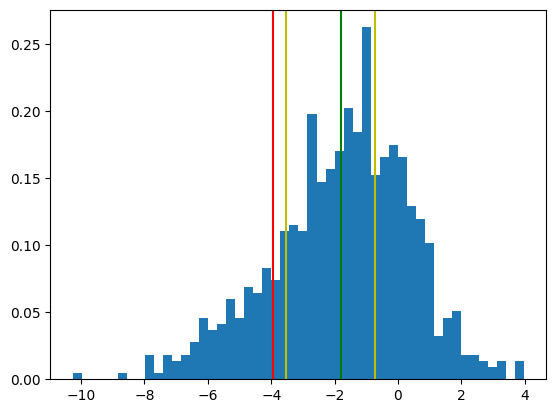

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 3358.241572367365 BIC 3367.516088429934 score -2.1980613187204225
Gaussian 0 mean= [-1.78587214] wgt= 1.0 cov= 4.750480550884046
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 3337.484747940969 BIC 3360.6710380973914 score -2.1805273577594817
Gaussian 0 mean= [-0.7260581] wgt= 0.6205961718844994 cov= 2.301296558201416
Gaussian 1 mean= [-3.51942486] wgt= 0.37940382811550066 cov= 3.9141966829110215
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 3346.0965119669067 BIC 3383.194576217182 score -2.182238867606099
Gaussian 0 mean= [-4.62614278] wgt= 0.22035309446575638 cov= 2.5886521571335086
Gaussian 1 mean= [0.16589366] wgt= 0.3289942740883725 cov= 1.6352832983462764
Gaussian 2 mean= [-1.82194726] wgt= 0.4506526314458711 cov= 1.3549052874372542
Cell Line 10 SK.N.DZ
Single mean [-0.61339453]
Double mean [0.04536069] [-2.12876301]
Gaussian discriminant -1.8456647480653132


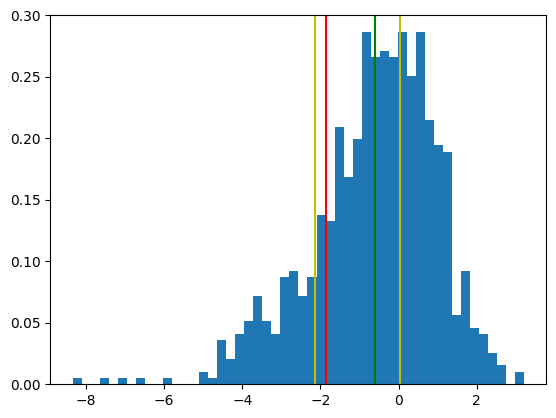

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 3182.3565523308307 BIC 3191.8423136024144 score -1.8740309860441218
Gaussian 0 mean= [-0.61339453] wgt= 1.0 cov= 2.4847829412015026
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 3110.4564009392543 BIC 3134.1708041182137 score -1.8280992930066358
Gaussian 0 mean= [0.04536069] wgt= 0.6970019573790917 cov= 1.0675491652767333
Gaussian 1 mean= [-2.12876301] wgt= 0.3029980426209083 cov= 2.4503200494740964
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 3121.590280106777 BIC 3159.533325193112 score -1.8311263444025807
Gaussian 0 mean= [-0.81627052] wgt= 0.3990600889449087 cov= 0.6136096715968039
Gaussian 1 mean= [-2.82397746] wgt= 0.19488544808642355 cov= 1.8751524548898553
Gaussian 2 mean= [0.64695402] wgt= 0.4060544629686678 cov= 0.6420323924830528
Cell Line 11 SK.N.SH
Single mean [-1.38483598]
Double mean [-3.09887536] [-0.11029544]
Gaussian discriminant -2.3789311129303545

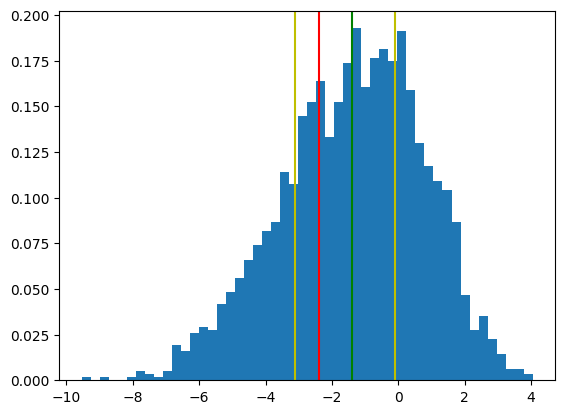

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 9982.735761546224 BIC 9994.209248911131 score -2.177812256993938
Gaussian 0 mean= [-1.38483598] wgt= 1.0 cov= 4.561938609220446
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 9927.846446022531 BIC 9956.530164434798 score -2.1645234495902512
Gaussian 0 mean= [-3.09887536] wgt= 0.42647028864216197 cov= 2.852882013294372
Gaussian 1 mean= [-0.11029544] wgt= 0.573529711357838 cov= 2.023707748588511
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 9935.340812289745 BIC 9981.234761749374 score -2.1648495880160947
Gaussian 0 mean= [0.52738421] wgt= 0.3879337968457386 cov= 1.3239370381230877
Gaussian 1 mean= [-4.17455845] wgt= 0.2134732356783825 cov= 1.9685306315024735
Gaussian 2 mean= [-1.75183632] wgt= 0.3985929674758791 cov= 1.2407247100258536
Cell Line 12 GM12878
Single mean [-1.17181107]
Double mean [-0.31916373] [-2.35473021]
Gaussian discriminant -1.8996948075997349


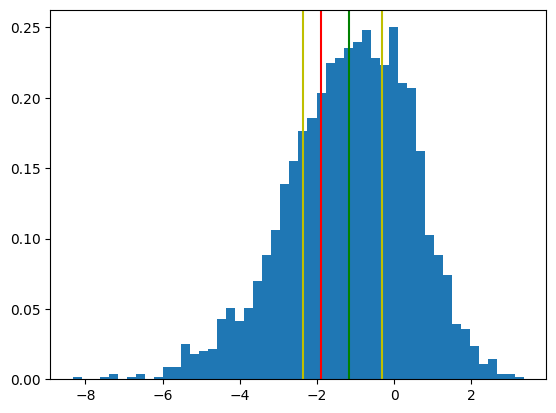

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 9039.252069527016 BIC 9050.800940547622 score -1.898960081867805
Gaussian 0 mean= [-1.17181107] wgt= 1.0 cov= 2.6118100329834357
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 8982.802391827892 BIC 9011.674569379407 score -1.8858348868911081
Gaussian 0 mean= [-0.31916373] wgt= 0.5811252799411861 cov= 1.2565520387576168
Gaussian 1 mean= [-2.35473021] wgt= 0.4188747200588138 cov= 2.0841148411376453
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 8983.989029866878 BIC 9030.184513949302 score -1.8848232513381415
Gaussian 0 mean= [-1.53681993] wgt= 0.4078905531186038 cov= 0.7634939206845027
Gaussian 1 mean= [-3.27068037] wgt= 0.1909981111336313 cov= 1.7075764905589927
Gaussian 2 mean= [0.19879028] wgt= 0.4011113357477648 cov= 0.8102451943965215
Cell Line 13 K562
Single mean [-1.00118801]
Double mean [-0.16934742] [-2.52524839]
Gaussian discriminant -2.026561897687802


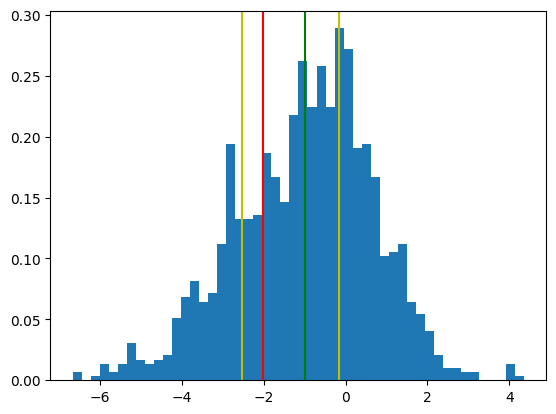

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 5179.52676133433 BIC 5189.918635787281 score -1.939852609195776
Gaussian 0 mean= [-1.00118801] wgt= 1.0 cov= 2.834394983745847
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 5159.514852030441 BIC 5185.494538162819 score -1.9301030180024141
Gaussian 0 mean= [-0.16934742] wgt= 0.646911900584309 cov= 1.4195537788199695
Gaussian 1 mean= [-2.52524839] wgt= 0.35308809941569086 cov= 1.8360671398625923
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 5171.433432686139 BIC 5213.000930497944 score -1.9323213765690177
Gaussian 0 mean= [-2.74952689] wgt= 0.32243738663057436 cov= 1.5273531838541767
Gaussian 1 mean= [-0.68584098] wgt= 0.4099904440148908 cov= 0.7581993145746955
Gaussian 2 mean= [0.62245075] wgt= 0.2675721693545349 cov= 1.118683167043305
Cell Line 14 IMR.90
Single mean [-0.75311386]
Double mean [-2.84239674] [0.39609188]
Gaussian discriminant -2.1496918225774464


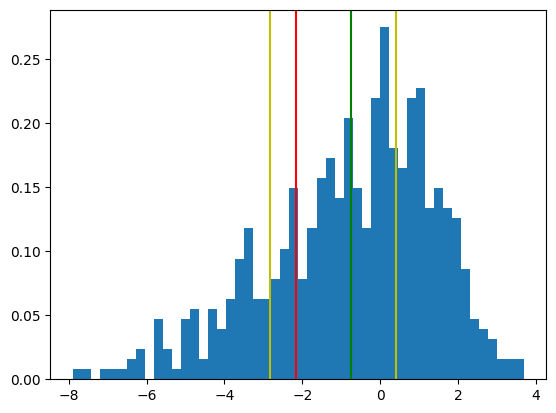

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 2402.149198096814 BIC 2410.7690346532668 score -2.180135634633467
Gaussian 0 mean= [-0.75311386] wgt= 1.0 cov= 4.583186144705691
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 2354.68866233196 BIC 2376.238253723093 score -2.131535147574509
Gaussian 0 mean= [-2.84239674] wgt= 0.3548586631773775 cov= 3.194549930811392
Gaussian 1 mean= [0.39609188] wgt= 0.6451413368226225 cov= 1.6253129007135778
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 2359.653484015786 BIC 2394.132830241598 score -2.1305940763779874
Gaussian 0 mean= [0.94518994] wgt= 0.45677181615649115 cov= 0.9976141883869574
Gaussian 1 mean= [-3.85749481] wgt= 0.20194467731345794 cov= 2.1639400452608273
Gaussian 2 mean= [-1.18918563] wgt= 0.34128350653005096 cov= 1.0606867113546277


In [8]:
filename = DATA_DIR + RCI_FILE
loader = RCI_Loader()

for CELL_LINE in range(15):
    gene_to_rci = loader.load_gene_rci_values(filename,CELL_LINE)
    logs = list(gene_to_rci.values())
    values = np.array(logs)
    values = values.reshape(-1, 1)

    model_1 = GaussianMixture(n_components=1, verbose=0, covariance_type='spherical', n_init=10) 
    model_1.fit(values)
    model_2 = GaussianMixture(n_components=2, verbose=0, covariance_type='spherical', n_init=10) 
    model_2.fit(values)
    model_3 = GaussianMixture(n_components=3, verbose=0, covariance_type='spherical', n_init=10) 
    model_3.fit(values)
    
    discrim = place_discriminant(
        min(logs),max(logs),
        model_2.means_[0],model_2.covariances_[0],model_2.weights_[0],
        model_2.means_[1],model_2.covariances_[1],model_2.weights_[1])
    
    print('Cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print('Single mean',model_1.means_[0])
    print('Double mean',model_2.means_[0],model_2.means_[1])
    print('Gaussian discriminant',discrim)
    if discrim is None:   # not expected, but just in case...
        discrim = model_1.means_
    middle = model_1.means_[0]
    left =  model_2.means_[0]
    right = model_2.means_[1]
    plot(logs,left,right,middle,discrim)
    
    show_gmm(model_1,values)
    show_gmm(model_2,values)
    show_gmm(model_3,values)